In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import median_abs_deviation

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:

%matplotlib inline
plt.rcParams["figure.figsize"] = (9, 6)


#  قراءة البيانات وتهيئتها

In [4]:

df = pd.read_csv("/content/ec2_cpu_utilization_24ae8d.csv")


display(df.head())


,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [5]:

# تحويل timestamp إلى نوع datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ترتيب البيانات حسب الوقت (مهم في الـ time series)
df = df.sort_values("timestamp").reset_index(drop=True)

# إزالة أي صفوف فيها قيم مفقودة بشكل عام (لو فيه)
df = df.dropna()

print("شكل البيانات بعد التنظيف:", df.shape)


شكل البيانات بعد التنظيف: (4032, 2)


#  وضع الليبل الحقيقي للأنومالي (من الـ ground truth)


In [6]:
anomalies_timestamp = [
    "2014-02-26 22:05:00",
    "2014-02-27 17:15:00"
]

In [7]:

# عمود is_anomaly: 1 = عادي ، -1 = شاذ
df["is_anomaly"] = 1
for ts in anomalies_timestamp:
    df.loc[df["timestamp"] == ts, "is_anomaly"] = -1

print("عدد النقاط الشاذة الحقيقية:", (df["is_anomaly"] == -1).sum())


عدد النقاط الشاذة الحقيقية: 2


# Feature Engineering

In [8]:

# نضيف متوسط متحرك و انحراف معياري متحرك و الفرق بين قيمة وقيمة
# window=12 تقريبًا ساعة واحدة إذا كانت القراءات كل 5 دقائق (12 * 5 = 60 دقيقة)
df["rolling_mean_12"] = df["value"].rolling(window=12, min_periods=1).mean()
df["rolling_std_12"]  = df["value"].rolling(window=12, min_periods=1).std()
df["diff_1"]          = df["value"].diff(1)


In [9]:
df = df.dropna().reset_index(drop=True)

In [10]:
print("شكل البيانات بعد إضافة الـ features:", df.shape)
display(df.head())


شكل البيانات بعد إضافة الـ features: (4031, 6)


,timestamp,value,is_anomaly,rolling_mean_12,rolling_std_12,diff_1
0,2014-02-14 14:35:00,0.134,1,0.133000,0.001414,0.002
1,2014-02-14 14:40:00,0.134,1,0.133333,0.001155,0.000
2,2014-02-14 14:45:00,0.134,1,0.133500,0.001000,0.000
3,2014-02-14 14:50:00,0.134,1,0.133600,0.000894,0.000
4,2014-02-14 14:55:00,0.134,1,0.133667,0.000816,0.000


#  تقسيم البيانات Train/Test بناءً على الزمن

In [11]:

split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()



In [12]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (3224, 6)
Test shape: (807, 6)


#تجهيز بيانات X و y للنماذج

In [13]:

feature_cols = ["value", "rolling_mean_12", "rolling_std_12", "diff_1"]

X_train = train[feature_cols].values
X_test  = test[feature_cols].values

y_train = train["is_anomaly"].values
y_test  = test["is_anomaly"].values


In [14]:

# Scaling للـ features (مهم لـ IsolationForest و LOF)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


#  دالة عامة لتقييم أي موديل

In [22]:
def evaluate_model(name, y_true, y_pred):
    print("\n" + "="*40)
    print(f"   نتائج الموديل: {name}")
    print("="*40)

    # مصفوفة الالتباس
    cm = confusion_matrix(y_true, y_pred, labels=[1, -1])

    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        labels=[1, -1],
        target_names=["Normal (1)", "Anomaly (-1)"]
    ))

    # رسم مصفوفة الالتباس
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, -1])
    disp.plot()
    plt.title(name)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

#  نموذج Robust Z-Score

In [23]:

# نحسب الـ median و MAD من بيانات التدريب فقط
median_train = np.median(train["value"])
mad_train    = median_abs_deviation(train["value"])

def robust_z(x):
    return 0.6745 * (x - median_train) / mad_train

# نحسب z-score لكل الداتا (train + test)
df["z_score"] = df["value"].apply(robust_z)

# نستخدم train فقط لاختيار threshold مناسب
abs_z_train = np.abs(df.loc[train.index, "z_score"])
threshold = abs_z_train.quantile(0.995)   # ممكن تغيرينه مثلاً 0.99 أو 0.997

print("Robust Z-score threshold المختار:", threshold)

# تنبؤات z-score على بيانات الاختبار فقط
abs_z_test = np.abs(df.loc[test.index, "z_score"])
z_preds = np.where(abs_z_test >= threshold, -1, 1)


Robust Z-score threshold المختار: 22.932999999999982



   نتائج الموديل: Robust Z-Score Baseline
Confusion Matrix (rows=true, cols=pred):
[[671 134]
 [  0   2]]

Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      0.83      0.91       805
Anomaly (-1)       0.01      1.00      0.03         2

    accuracy                           0.83       807
   macro avg       0.51      0.92      0.47       807
weighted avg       1.00      0.83      0.91       807



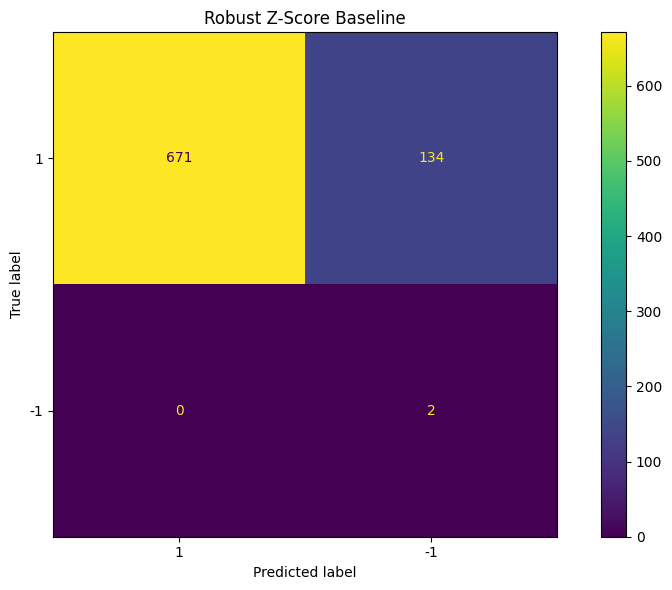

In [24]:
# تقييم الموديل
evaluate_model("Robust Z-Score Baseline", y_test, z_preds)

#  نموذج Isolation Forest


   نتائج الموديل: Isolation Forest
Confusion Matrix (rows=true, cols=pred):
[[792  13]
 [  0   2]]

Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      0.98      0.99       805
Anomaly (-1)       0.13      1.00      0.24         2

    accuracy                           0.98       807
   macro avg       0.57      0.99      0.61       807
weighted avg       1.00      0.98      0.99       807



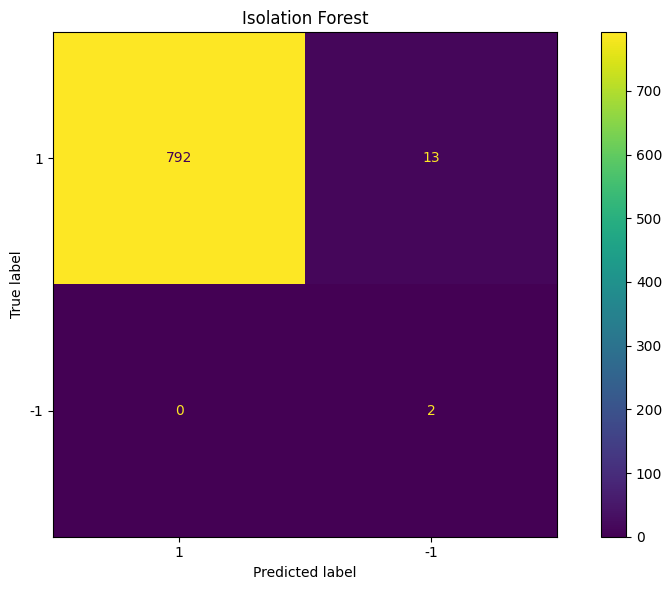

In [25]:

# نسبة التلوث (تقريبًا 1% من البيانات أنومالي)
contamination = 0.01

iso_forest = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=contamination,
    max_features=1.0,
    random_state=42,
    n_jobs=-1
)

# تدريب الموديل على بيانات التدريب المقيّسة
iso_forest.fit(X_train_scaled)

# التنبؤ على بيانات الاختبار
iso_preds = iso_forest.predict(X_test_scaled)

# تقييم الموديل
evaluate_model("Isolation Forest", y_test, iso_preds)


#  نموذج Local Outlier Factor (LOF)


   نتائج الموديل: Local Outlier Factor (LOF)
Confusion Matrix (rows=true, cols=pred):
[[800   5]
 [  1   1]]

Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      0.99      1.00       805
Anomaly (-1)       0.17      0.50      0.25         2

    accuracy                           0.99       807
   macro avg       0.58      0.75      0.62       807
weighted avg       1.00      0.99      0.99       807



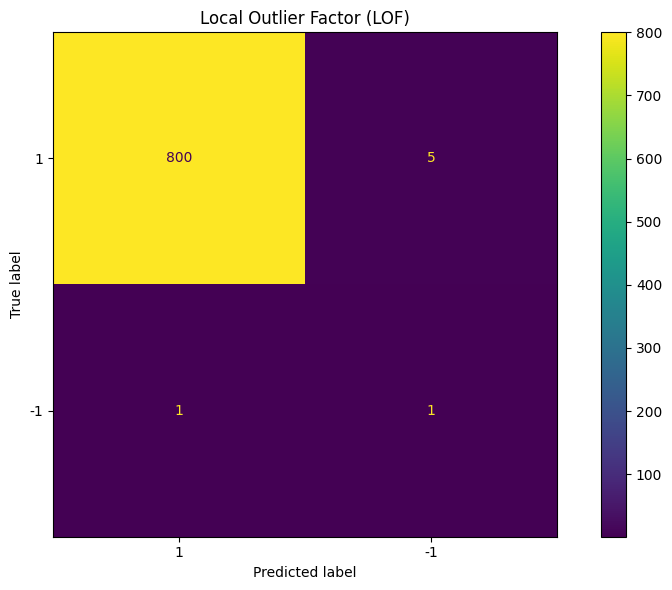

In [26]:

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=contamination,
    novelty=True,   # عشان نقدر نستخدمه على بيانات جديدة (test)
    n_jobs=-1
)

# تدريب الموديل على بيانات التدريب
lof.fit(X_train_scaled)

# التنبؤ على بيانات الاختبار
lof_preds = lof.predict(X_test_scaled)

# تقييم الموديل
evaluate_model("Local Outlier Factor (LOF)", y_test, lof_preds)


In [28]:
import joblib, os

# نتأكد أن الموديل والأشياء المهمة موجودة
print("عندي iso_forest؟", 'iso_forest' in globals())
print("عندي scaler؟", 'scaler' in globals())
print("عندي feature_cols؟", 'feature_cols' in globals())

# نحفظ كل الأشياء المهمة مع بعض
artifacts = {
    "model": iso_forest,
    "scaler": scaler,
    "feature_cols": feature_cols
}

save_path = "/content/cpu_anomaly_iso_forest.pkl"

joblib.dump(artifacts, save_path)

print("\nالمسار اللي حفظت فيه:", save_path)
print("هل الملف موجود فعلاً؟", os.path.exists(save_path))

# نعرض الملفات الموجودة في /content
print("\nالملفات في /content الآن:")
print(os.listdir("/content"))


عندي iso_forest؟ True
عندي scaler؟ True
عندي feature_cols؟ True

المسار اللي حفظت فيه: /content/cpu_anomaly_iso_forest.pkl
هل الملف موجود فعلاً؟ True

الملفات في /content الآن:
['.config', 'cpu_anomaly_iso_forest.pkl', 'ec2_cpu_utilization_53ea38.csv', 'ec2_cpu_utilization_24ae8d.csv', 'sample_data']


In [29]:
import joblib
import numpy as np

# 1) تحميل الموديل من الملف
loaded_artifacts = joblib.load("/content/cpu_anomaly_iso_forest.pkl")

model_loaded = loaded_artifacts["model"]
scaler_loaded = loaded_artifacts["scaler"]
feature_cols_loaded = loaded_artifacts["feature_cols"]

print("تم تحميل الموديل بنجاح ✅")
print("Features المستخدمة:", feature_cols_loaded)


تم تحميل الموديل بنجاح ✅
Features المستخدمة: ['value', 'rolling_mean_12', 'rolling_std_12', 'diff_1']


In [30]:
# 2) تجهيز بيانات الاختبار بنفس الشكل
X_test_loaded = test[feature_cols_loaded].values
X_test_loaded_scaled = scaler_loaded.transform(X_test_loaded)


In [31]:
# 3) التنبؤ باستخدام الموديل بعد التحميل
iso_preds_loaded = model_loaded.predict(X_test_loaded_scaled)


In [32]:
# 4) مقارنة التنبؤات قبل وبعد الحفظ
print("هل التنبؤات قبل وبعد التحميل متطابقة؟",
      np.array_equal(iso_preds_loaded, iso_preds))


هل التنبؤات قبل وبعد التحميل متطابقة؟ True



   نتائج الموديل: Isolation Forest (Loaded Model)
Confusion Matrix (rows=true, cols=pred):
[[792  13]
 [  0   2]]

Classification Report:
              precision    recall  f1-score   support

  Normal (1)       1.00      0.98      0.99       805
Anomaly (-1)       0.13      1.00      0.24         2

    accuracy                           0.98       807
   macro avg       0.57      0.99      0.61       807
weighted avg       1.00      0.98      0.99       807



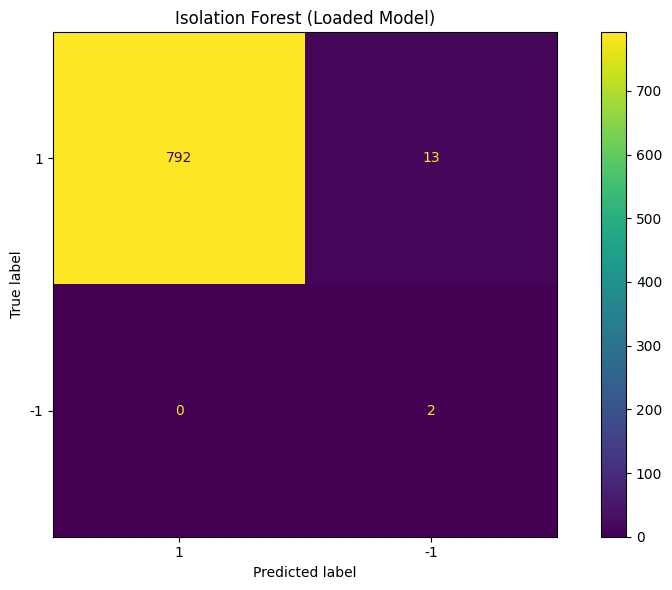

In [33]:
# 5) عرض التقييم والكونفيوجن ماتريكس
evaluate_model("Isolation Forest (Loaded Model)", y_test, iso_preds_loaded)

# تحربه بيانات جديده

In [35]:
# بيانات جديدة
new_values = [0.135, 0.142, 0.150, 0.160, 0.155, 0.148, 0.152,
              0.310, 0.450, 0.620]  # طبيعي ثم شاذ


In [36]:
new_data_anomaly = [
    0.310, 0.450, 0.620
]


In [37]:
import pandas as pd

# بيانات جديدة (قيمي وقيمي انتي)
new_values = [0.135, 0.142, 0.150, 0.160, 0.155, 0.148, 0.152,
              0.310, 0.450, 0.620]  # طبيعي ثم شاذ

df_new = pd.DataFrame({"value": new_values})

# نعيد تطبيق نفس الـ feature engineering اللي استخدمناها وقت التدريب
df_new["rolling_mean_12"] = df_new["value"].rolling(window=12, min_periods=1).mean()
df_new["rolling_std_12"]  = df_new["value"].rolling(window=12, min_periods=1).std()
df_new["diff_1"]          = df_new["value"].diff().fillna(0)

# استخراج الـ features
X_new = df_new[feature_cols].values

# scaling
X_new_scaled = scaler_loaded.transform(X_new)

# prediction
new_preds = model_loaded.predict(X_new_scaled)

df_new["prediction"] = new_preds

df_new


,value,rolling_mean_12,rolling_std_12,diff_1,prediction
0,0.135,0.135000,NaN,0.000,1
1,0.142,0.138500,0.004950,0.007,1
2,0.150,0.142333,0.007506,0.008,1
3,0.160,0.146750,0.010751,0.010,1
4,0.155,0.148400,0.010015,-0.005,1
5,0.148,0.148333,0.008959,-0.007,1
6,0.152,0.148857,0.008295,0.004,1
7,0.310,0.169000,0.057488,0.158,1
8,0.450,0.200222,0.108006,0.140,-1
9,0.620,0.242200,0.167303,0.170,-1


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_and_plot(values, model, scaler, feature_cols, title="New Data Anomaly Detection"):
    # 1) نحط القيم في DataFrame
    df_new = pd.DataFrame({"value": values})

    # 2) نعيد نفس الـ Feature Engineering المستخدم في التدريب
    df_new["rolling_mean_12"] = df_new["value"].rolling(window=12, min_periods=1).mean()
    df_new["rolling_std_12"]  = df_new["value"].rolling(window=12, min_periods=1).std()
    df_new["diff_1"]          = df_new["value"].diff().fillna(0)

    # نتأكد إن الأعمدة مرتبة مثل feature_cols
    X_new = df_new[feature_cols].values

    # 3) نطبّق الـ scaler
    X_new_scaled = scaler.transform(X_new)

    # 4) تنبؤ المودل
    preds = model.predict(X_new_scaled)
    df_new["prediction"] = preds   # 1 = طبيعي ، -1 = شاذ

    # 5) ملخص نصي
    n_points = len(df_new)
    n_anom = (df_new["prediction"] == -1).sum()
    print(f"عدد النقاط الكلي: {n_points}")
    print(f"عدد النقاط الشاذة (prediction = -1): {n_anom}")

    # لو فيه أنومالي، نطبع أماكنها
    if n_anom > 0:
        print("\nصفوف الأنومالي:")
        display(df_new[df_new["prediction"] == -1])
    else:
        print("\nلا يوجد نقاط شاذة في هذه البيانات بحسب المودل.")

    # 6) الرسم (mini-dashboard)
    plt.figure(figsize=(10, 5))
    plt.plot(df_new.index, df_new["value"], label="CPU value", marker="o")

    normal = df_new[df_new["prediction"] == 1]
    anom   = df_new[df_new["prediction"] == -1]

    # نقاط طبيعية
    plt.scatter(normal.index, normal["value"], label="Normal", color="blue")
    # نقاط شاذة
    if len(anom) > 0:
        plt.scatter(anom.index, anom["value"], label="Anomaly", color="red", s=80)

    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("CPU Utilization")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_new


عدد النقاط الكلي: 10
عدد النقاط الشاذة (prediction = -1): 2

صفوف الأنومالي:


,value,rolling_mean_12,rolling_std_12,diff_1,prediction
8,0.45,0.200222,0.108006,0.14,-1
9,0.62,0.242200,0.167303,0.17,-1


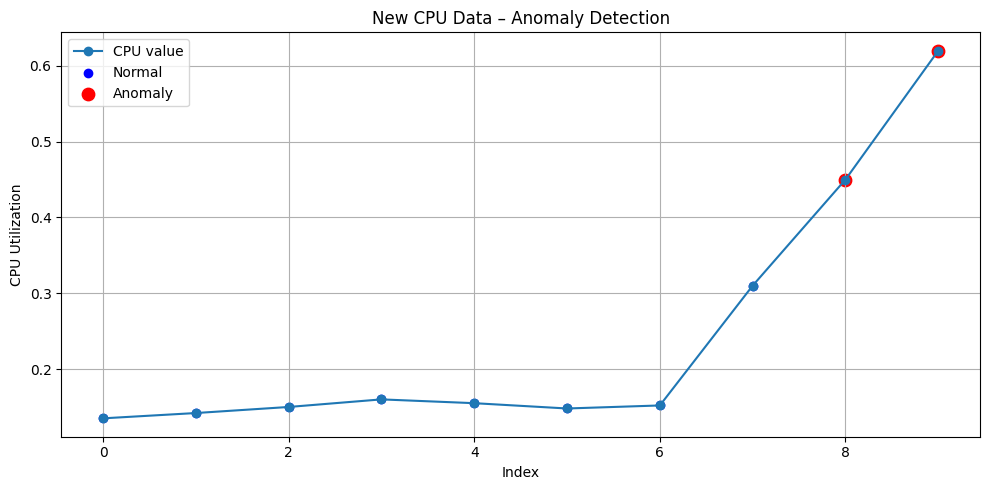

In [39]:
# مثال بيانات جديدة: أول 7 نقاط طبيعية، وآخر 3 شاذة (قيم عالية)
new_values = [
    0.135, 0.142, 0.150, 0.160, 0.155, 0.148, 0.152,  # طبيعي
    0.310, 0.450, 0.620                               # شاذ (ارتفاع قوي)
]

df_result = detect_and_plot(
    values=new_values,
    model=model_loaded,          # المودل اللي حمّلناه من الملف
    scaler=scaler_loaded,        # الـ scaler المحمّل
    feature_cols=feature_cols_loaded,
    title="New CPU Data – Anomaly Detection"
)


In [40]:
# التوقعات من المودل
print(df_new[["value", "prediction"]])

# الليبل الحقيقي للبيانات الجديدة
true_labels = [1,1,1,1,1,1,1, -1, -1, -1]   # عدّليها حسب بياناتك

# حساب الدقة
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, new_preds)

print("\nAccuracy on the new dataset:", accuracy)


   value  prediction
0  0.135           1
1  0.142           1
2  0.150           1
3  0.160           1
4  0.155           1
5  0.148           1
6  0.152           1
7  0.310           1
8  0.450          -1
9  0.620          -1

Accuracy on the new dataset: 0.9


===== Summary =====
عدد النقاط: 10
عدد الأنومالي: 2

صفوف الأنومالي:
   value  rolling_mean_12  rolling_std_12  diff_1  prediction
8   0.45         0.200222        0.108006    0.14          -1
9   0.62         0.242200        0.167303    0.17          -1

Accuracy: 0.9


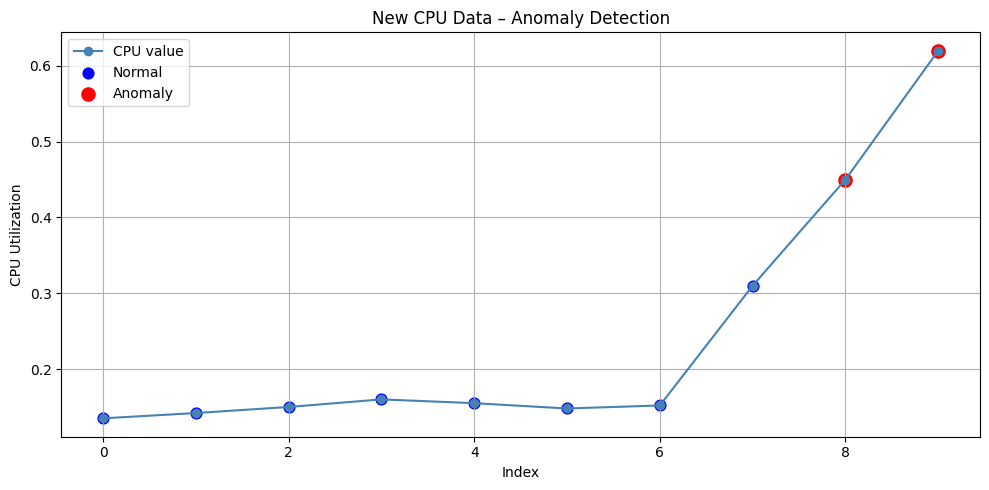

,value,rolling_mean_12,rolling_std_12,diff_1,prediction
0,0.135,0.135000,NaN,0.000,1
1,0.142,0.138500,0.004950,0.007,1
2,0.150,0.142333,0.007506,0.008,1
3,0.160,0.146750,0.010751,0.010,1
4,0.155,0.148400,0.010015,-0.005,1
5,0.148,0.148333,0.008959,-0.007,1
6,0.152,0.148857,0.008295,0.004,1
7,0.310,0.169000,0.057488,0.158,1
8,0.450,0.200222,0.108006,0.140,-1
9,0.620,0.242200,0.167303,0.170,-1


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import joblib


# 1) تحميل المودل

artifacts = joblib.load("/content/cpu_anomaly_iso_forest.pkl")
model = artifacts["model"]
scaler = artifacts["scaler"]
feature_cols = artifacts["feature_cols"]


# 2) بيانات جديدة للتجربة

new_values = [0.135, 0.142, 0.150, 0.160, 0.155, 0.148, 0.152,
              0.310, 0.450, 0.620]

df_new = pd.DataFrame({"value": new_values})


# 3) Feature Engineering

df_new["rolling_mean_12"] = df_new["value"].rolling(window=12, min_periods=1).mean()
df_new["rolling_std_12"]  = df_new["value"].rolling(window=12, min_periods=1).std()
df_new["diff_1"]          = df_new["value"].diff().fillna(0)

X_new = df_new[feature_cols]
X_scaled = scaler.transform(X_new)

# 4) التوقعات

preds = model.predict(X_scaled)
df_new["prediction"] = preds


# 5) Summary للطباعة

print("===== Summary =====")
print("عدد النقاط:", len(df_new))
print("عدد الأنومالي:", sum(df_new["prediction"] == -1))
print("====================\n")


# 6) جدول الأنومالي

anom = df_new[df_new["prediction"] == -1]
print("صفوف الأنومالي:")
print(anom)


# 7) Accuracy

true_labels = [1,1,1,1,1,1,1, -1, -1, -1]

acc = accuracy_score(true_labels, preds)
print("\nAccuracy:", acc)


# 8) الرسم

plt.figure(figsize=(10,5))
plt.plot(df_new.index, df_new["value"], marker="o", label="CPU value", color="steelblue")

# نقاط طبيعية
normal = df_new[df_new["prediction"] == 1]
plt.scatter(normal.index, normal["value"], color="blue", label="Normal", s=60)

# نقاط شاذة
anom = df_new[df_new["prediction"] == -1]
if len(anom) > 0:
    plt.scatter(anom.index, anom["value"], color="red", label="Anomaly", s=90)

plt.title("New CPU Data – Anomaly Detection")
plt.xlabel("Index")
plt.ylabel("CPU Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9) عرض الجدول كامل

df_new
